In [1]:
# Import libraries
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

# Older version of tensorflow to avoid errors due to update/ version change on 27/3/20
!pip install tensorflow==1.14.0

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
# Dataset saved as a dataframe with three column names: commentNumber, comment and aggClass
dfComments = pd.read_csv('/content/drive/My Drive/MSc Computing/Data Wrangling Assessment 2/Dataset.csv', names=['commentNumber', 'comment', 'aggClass'], sep = ',')

In [3]:
# Check data has loaded correctly and column names applied
dfComments.head()

,commentNumber,comment,aggClass
0,facebook_corpus_msr_1723796,Well said sonu..you have courage to stand agai...,OAG
1,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",OAG
3,facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,OAG
4,facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",NAG


In [0]:
# Delete comment number as it is not necessary for classifaction and comments are indexed by pandas anyway
del dfComments['commentNumber']

In [5]:
# Check deletion of commentNumber column
dfComments.head()

,comment,aggClass
0,Well said sonu..you have courage to stand agai...,OAG
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,"Now question is, Pakistan will adhere to this?",OAG
3,Pakistan is comprised of fake muslims who does...,OAG
4,"??we r against cow slaughter,so of course it w...",NAG


In [6]:
# Assign column names to arrays
comment = dfComments['comment'].values
aggClass = dfComments['aggClass'].values

dfComments.info()

# Check for null values
dfComments.isnull().any()

print(dfComments.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   11999 non-null  object
 1   aggClass  11999 non-null  object
dtypes: object(2)
memory usage: 187.6+ KB
(11999, 2)


In [7]:
 # Previous attempts to make aggClass column INT instead of string
 # Create dictionary to remap aggClass object-string to binary integers
 #dict = {'OAG': 0.1, 'CAG': 0.2, 'NAG': 0.3}

 # dfComments['aggClass'] = pd.to_numeric(dfComments.aggClass, errors ='coerce')
 #  print(aggClass.dtype)

#dfComments.replace({'aggClass': dict})
#dfComments['aggClass'] = dfComments['aggClass'].map({'OAG': 2, 'CAG': 1, 'NAG': 0})
#dfComments.head(20)

# Working attempt
dfComments.loc[dfComments["aggClass"]== "OAG", "aggClass"] = 0
dfComments.loc[dfComments["aggClass"]== "CAG", "aggClass"] = 1
dfComments.loc[dfComments["aggClass"]== "NAG", "aggClass"] = 2
dfComments.head()

,comment,aggClass
0,Well said sonu..you have courage to stand agai...,0
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",2
2,"Now question is, Pakistan will adhere to this?",0
3,Pakistan is comprised of fake muslims who does...,0
4,"??we r against cow slaughter,so of course it w...",2


In [0]:
# Split into training and testing data
from sklearn.model_selection import train_test_split

comment_train, comment_test, y_train, y_test = train_test_split(comment, aggClass, test_size=0.2)

In [0]:
# Tokenize (only training data)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(comment_train)

x_train = tokenizer.texts_to_sequences(comment_train)
x_test = tokenizer.texts_to_sequences(comment_test)

In [10]:
# Find vocab size and print instance of train data
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
print(comment_train[5])
print(x_train[5])

20837
Nifty 5300 in 2010-11, 2016 we are at 8700. Don't you feel nifty racing towards 12000
[456, 6, 1978, 806, 615, 20, 9, 48, 3198, 57, 10, 217, 456, 551, 4626]


In [0]:
# Pad the length

from keras.preprocessing.sequence import pad_sequences

maxlen = 50

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [12]:
 # Creating embedding layer with GloVe file

embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.array(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 6118 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items(): # t = tokenizer, 
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [14]:
eLayer = layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

In [0]:
 # Define model function
 
def cnn_text_classifier():
    embedding_dim = 50

    model = Sequential()
    model.add(eLayer)
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [16]:
# Call model function and train model
# Can't compile, error with input shape. Unresolveable after research of error at my level of experience
model = cnn_text_classifier()
training = model.fit(x_train, y_train, epochs=10, verbose=False, validation_data=(x_test, y_test), batch_size=10)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2083700   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,084,721
Trainable params: 1,021
Non-trainable params: 2,083,700
_________________________________________________________________


In [17]:
 # Calculate display and accuracy
 
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.2f}".format(accuracy))

Training Accuracy: 0.35
Testing Accuracy:  0.35


In [0]:
# Set up graph to show loss and accuracy of model

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(training):
    acc = training.history['acc']
    val_acc = training.history['val_acc']
    loss = training.history['loss']
    val_loss = training.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 2)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


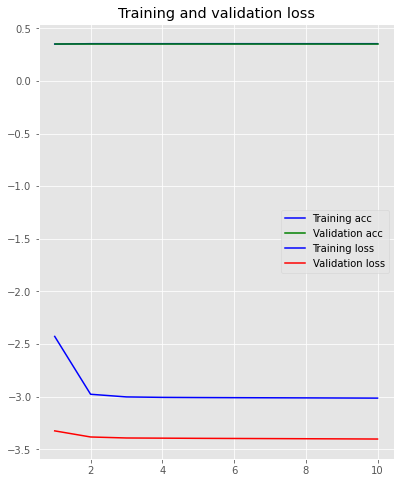

In [19]:
plot_history(training)